In [4]:
# --- core imports
import numpy as np
from dataclasses import dataclass
from typing import Callable, List, Tuple, FrozenSet, Dict
from collections import defaultdict, Counter
import math
import random

# --- sci/metric/cluster
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Minimal plotting defaults
plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["axes.grid"] = True


In [38]:
Window = FrozenSet[Tuple[int, int]]  # {(Δt, neuron), ...}, Δt in [-D, D]

@dataclass
class BenchConfig:
    N: int                   # number of neurons
    D: int                   # window half-width (ms)
    spikes_per_motif: int    # spikes inside the motif (including trigger)
    motif_repetitions: int   # number of positive windows
    total_negatives: int     # number of negative windows
    background_spikes: float # parameter for background spike count per window (lambda for Poisson or fixed K)
    bg_mode: str = "poisson" # "poisson" or "fixed"
    focus_neuron: int = 0    # the trigger neuron we cluster by (spike-oriented per-neuron scan)

def make_bg_sampler(mode: str, value: float) -> Callable[[], int]:
    """
    Returns a sampler that produces the number of background spikes per window.
    - "poisson": value is lambda
    - "fixed":   value is exact integer count
    """
    if mode == "poisson":
        lam = float(value)
        return lambda: int(np.random.poisson(lam))
    elif mode == "fixed":
        k = int(round(value))
        return lambda: k
    else:
        raise ValueError("bg_mode must be 'poisson' or 'fixed'")


In [39]:
def _unique_pairs(pairs: List[Tuple[int,int]]) -> List[Tuple[int,int]]:
    """Keep first occurrence order while removing duplicates."""
    seen = set()
    out = []
    for p in pairs:
        if p not in seen:
            seen.add(p)
            out.append(p)
    return out

def make_single_motif_template(cfg: BenchConfig) -> Window:
    """
    Build a single motif as a set of (Δt, neuron) pairs.
    Includes the trigger at (0, focus_neuron).
    Remaining spikes are sampled uniformly in Δt ∈ [-D, D], neuron ∈ [0, N-1].
    """
    D, N = cfg.D, cfg.N
    # Always include trigger spike
    pairs = [(0, cfg.focus_neuron)]
    # Sample the rest
    need = cfg.spikes_per_motif - 1
    # guard
    need = max(0, need)
    while len(pairs) < cfg.spikes_per_motif:
        dt = np.random.randint(-D, D+1)
        n  = np.random.randint(0, N)
        pairs.append((dt, n))
        pairs = _unique_pairs(pairs)
    return frozenset(sorted(pairs))

def _sample_background_pairs(cfg: BenchConfig, K: int, forbid: Window = frozenset()) -> Window:
    """Sample K background (Δt, neuron) pairs, avoiding duplicates and optionally avoiding 'forbid' pairs."""
    D, N = cfg.D, cfg.N
    pairs = set()
    tries = 0
    while len(pairs) < K and tries < K*20:
        dt = np.random.randint(-D, D+1)
        n  = np.random.randint(0, N)
        p = (dt, n)
        if p not in pairs and p not in forbid:
            pairs.add(p)
        tries += 1
    return frozenset(sorted(pairs))

def generate_window_dataset(cfg: BenchConfig) -> Tuple[List[Window], np.ndarray, Dict]:
    """
    Returns:
      windows: list[Window] length W
      y_true:  np.array of {0,1} labels (1=motif window, 0=background-only)
      info:    dict with motif template and bookkeeping
    Strategy:
      - W_pos = cfg.motif_repetitions positives (motif + background noise)
      - W_neg = cfg.motif_repetitions negatives (background noise only)
      - All windows are assigned to the same 'focus' trigger neuron (per-neuron pipeline)
    """
    bgK = make_bg_sampler(cfg.bg_mode, cfg.background_spikes)
    motif = make_single_motif_template(cfg)
    W_pos, W_neg = [], []
    # positive windows
    for _ in range(cfg.motif_repetitions):
        k = bgK()
        win = set(motif)
        # add background without duplicating existing motif pairs
        bg = _sample_background_pairs(cfg, k, forbid=frozenset())
        win |= set(bg)
        W_pos.append(frozenset(sorted(win)))
    # negative windows (ensure they don't fully contain the entire motif)
    for _ in range(cfg.total_negatives):
        k = bgK()
        neg = _sample_background_pairs(cfg, k, forbid=frozenset())  # background
        # If by chance neg includes the full motif (extremely unlikely), resample one element
        if motif.issubset(neg):
            # replace one random element
            neg = set(neg)
            neg.pop()
            neg = frozenset(sorted(neg))
        W_neg.append(neg)

    windows = W_pos + W_neg
    y_true = np.array([1]*len(W_pos) + [0]*len(W_neg), dtype=int)
    info = {"motif": motif, "W_pos": len(W_pos), "W_neg": len(W_neg)}
    return windows, y_true, info


In [40]:
# --- Similarity functions ---
def sim_overlap_min(A: Window, B: Window) -> float:
    """
    |A ∩ B| / min(|A|, |B|)  ∈ [0,1]
    Good for small-spike motifs; partial match doesn't get overly punished.
    """
    if len(A) == 0 or len(B) == 0:
        return 0.0
    return len(A.intersection(B)) / min(len(A), len(B))

def sim_jaccard(A: Window, B: Window) -> float:
    """
    |A ∩ B| / |A ∪ B| ∈ [0,1]
    """
    U = A.union(B)
    if len(U) == 0:
        return 0.0
    return len(A.intersection(B)) / len(U)

# Hook for future ε-tolerant matching (time tolerance on Δt)
def sim_overlap_min_tolerant(A: Window, B: Window, eps: int = 1) -> float:
    """
    ε-tolerant match on Δt with exact neuron match. Greedy 1-1 matching.
    """
    if len(A) == 0 or len(B) == 0:
        return 0.0
    # Index B by neuron for speed
    by_neuron = defaultdict(list)
    for dt, n in B:
        by_neuron[n].append(dt)
    for n in by_neuron:
        by_neuron[n] = sorted(by_neuron[n])

    matched = 0
    used = set()  # (n, dt) used in B
    for dtA, nA in sorted(A):
        if nA not in by_neuron:
            continue
        # find a dtB within eps not yet used
        candidates = by_neuron[nA]
        # binary search neighborhood
        lo = 0
        hi = len(candidates)-1
        # linear scan around dtA suffices (small)
        best = None
        for dtB in candidates:
            if abs(dtB - dtA) <= eps and (nA, dtB) not in used:
                best = dtB
                break
        if best is not None:
            matched += 1
            used.add((nA, best))
    return matched / min(len(A), len(B))

# --- Distance builder (condensed) ---
def condensed_distance(windows: List[Window],
                       sim_fn: Callable[[Window, Window], float]) -> np.ndarray:
    """
    Build condensed distance vector 1 - sim(A,B) for SciPy linkage.
    """
    n = len(windows)
    m = n*(n-1)//2
    out = np.empty(m, dtype=float)
    idx = 0
    for i in range(n-1):
        Ai = windows[i]
        for j in range(i+1, n):
            s = sim_fn(Ai, windows[j])
            out[idx] = 1.0 - s
            idx += 1
    return out


In [41]:
@dataclass
class SweepResult:
    thresholds: np.ndarray
    ari: np.ndarray
    pair_precision: np.ndarray
    pair_recall: np.ndarray
    pair_f1: np.ndarray
    best_idx: int
    best: Dict

def pairwise_PR_on_positive(y_true: np.ndarray, y_pred: np.ndarray) -> Tuple[float,float,float]:
    """
    Evaluate clustering as pair detection for the positive class (label=1).
    - True pair: two positive windows that should be in the same group
    - Predicted pair: any two windows assigned to the same cluster (across all)
    Precision/Recall computed w.r.t. the set of positive pairs only.
    """
    n = len(y_true)
    # set of true positive pairs
    true_pairs = set()
    pos_ids = np.where(y_true == 1)[0]
    for i in range(len(pos_ids)-1):
        for j in range(i+1, len(pos_ids)):
            true_pairs.add((pos_ids[i], pos_ids[j]))

    # predicted same-cluster pairs
    pred_pairs = set()
    cluster_to_ids = defaultdict(list)
    for i, c in enumerate(y_pred):
        cluster_to_ids[c].append(i)
    for ids in cluster_to_ids.values():
        if len(ids) >= 2:
            for a in range(len(ids)-1):
                for b in range(a+1, len(ids)):
                    i, j = ids[a], ids[b]
                    pred_pairs.add((min(i,j), max(i,j)))

    if len(pred_pairs) == 0:
        precision = 1.0 if len(true_pairs) == 0 else 0.0
    else:
        precision = len(pred_pairs & true_pairs) / len(pred_pairs)
    recall = (len(pred_pairs & true_pairs) / len(true_pairs)) if len(true_pairs) > 0 else 0.0
    f1 = (2*precision*recall / (precision+recall)) if (precision+recall) > 0 else 0.0
    return precision, recall, f1

class ClusteringLab:
    def __init__(self, windows: List[Window], y_true: np.ndarray,
                 sim: Callable[[Window, Window], float] = sim_overlap_min):
        self.windows = windows
        self.y_true = y_true
        self.sim = sim
        # Build condensed distance and linkage ONCE
        self._condensed = condensed_distance(self.windows, self.sim)
        self._Z = linkage(self._condensed, method="complete")  # single dendrogram

    def sweep_thresholds(self, thresholds: np.ndarray) -> SweepResult:
        ari = []
        pp = []
        rr = []
        ff = []
        best_idx = 0
        best_score = -1
        best = {}
        for i, t in enumerate(thresholds):
            y_pred = fcluster(self._Z, t, criterion="distance")
            ari_i = adjusted_rand_score(self.y_true, y_pred)
            p, r, f1 = pairwise_PR_on_positive(self.y_true, y_pred)
            ari.append(ari_i); pp.append(p); rr.append(r); ff.append(f1)
            # pick best by F1 on positive class; tie-break by ARI
            score = (f1, ari_i)
            if score > (best.get("f1", -1), best.get("ari", -1)):
                best_idx = i
                best = {"threshold": t, "f1": f1, "precision": p, "recall": r, "ari": ari_i,
                        "n_clusters": len(np.unique(y_pred))}
        return SweepResult(np.array(thresholds), np.array(ari),
                           np.array(pp), np.array(rr), np.array(ff),
                           best_idx, best)

    def labels_at(self, threshold: float) -> np.ndarray:
        return fcluster(self._Z, threshold, criterion="distance")


In [43]:
# ---- choose your minimal parameters here ----
N=10
D=30
cfg = BenchConfig(
    N=N,                  # neurons
    D=D,                  # window half-width (ms)
    spikes_per_motif=5,    # small motifs are the hard regime
    motif_repetitions=5,  # number of positive windows
    total_negatives=100,  # number of positive windows
    background_spikes=0.03*N*D, # mean background spikes per window
    bg_mode="poisson",     # "poisson" or "fixed"
    focus_neuron=0         # cluster per neuron (spike-oriented)
)

windows, y_true, info = generate_window_dataset(cfg)
print("Motif pairs:", sorted(list(info["motif"])))
print("Windows: total =", len(windows), "| positives =", info["W_pos"], "| negatives =", info["W_neg"])
print("Example window sizes (first 5):", [len(w) for w in windows[:5]])


Motif pairs: [(-11, 0), (0, 0), (2, 9), (6, 2), (16, 7)]
Windows: total = 105 | positives = 5 | negatives = 100
Example window sizes (first 5): [15, 21, 12, 18, 15]


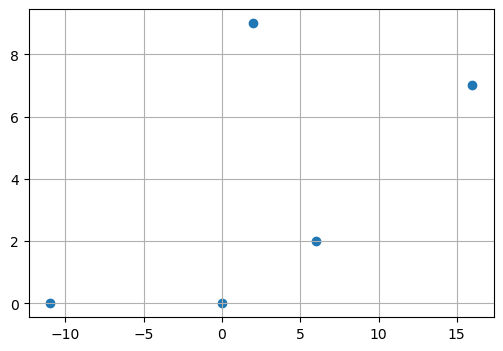

In [44]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(*np.array(list(info["motif"])).T)
plt.show()

In [45]:
# Pick a compact threshold grid in [0, 1.0]
# (distance = 1 - similarity; lower cuts = tighter clusters)
thresholds = np.linspace(0, 5, 101)

lab = ClusteringLab(windows, y_true, sim=sim_overlap_min)  # swap similarity here
res = lab.sweep_thresholds(thresholds)

print("Best (by F1 on positives):")
print(res.best)

# Optional: also grab the labels at the chosen cut
y_pred_best = lab.labels_at(res.best["threshold"])
# Show cluster sizes
sizes = Counter(y_pred_best)
print("Top cluster sizes:", sorted(sizes.values(), reverse=True)[:10])


C:\Users\miles\anaconda3\envs\neuro\lib\site-packages\sklearn\metrics\cluster\_supervised.py:50: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(labels_pred)
C:\Users\miles\anaconda3\envs\neuro\lib\site-packages\sklearn\metrics\cluster\_supervised.py:50: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(labels_pred)
C:\Users\miles\anaconda3\envs\neuro\lib\site-packages\sklearn\metrics\cluster\_supervised.py:50: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(labels_pred)
C:\Users\miles\anaconda3\envs\neuro\lib\site-packages\sklearn\metrics\cluster\_supervised.py:50: UserWa

Best (by F1 on positives):
{'threshold': np.float64(0.6000000000000001), 'f1': 0.5333333333333333, 'precision': 0.8, 'recall': 0.4, 'ari': 0.00018477935497222765, 'n_clusters': 101}
Top cluster sizes: [3, 2, 2, 1, 1, 1, 1, 1, 1, 1]


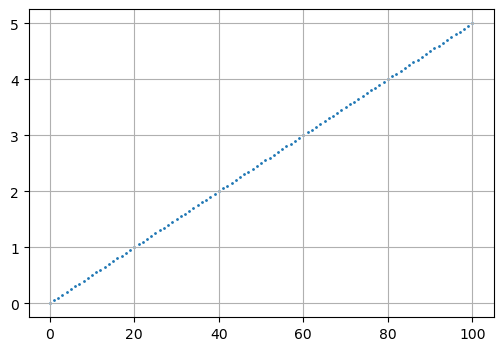

In [46]:
plt.figure()
plt.scatter(np.arange(len(thresholds)),thresholds,s=1)
plt.show()

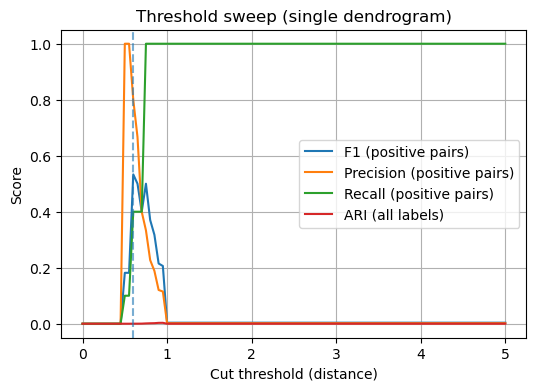

In [47]:
fig, ax = plt.subplots(1,1)
ax.plot(res.thresholds, res.pair_f1, label="F1 (positive pairs)")
ax.plot(res.thresholds, res.pair_precision, label="Precision (positive pairs)")
ax.plot(res.thresholds, res.pair_recall, label="Recall (positive pairs)")
ax.plot(res.thresholds, res.ari, label="ARI (all labels)")
ax.axvline(res.best["threshold"], linestyle="--", alpha=0.6)
ax.set_xlabel("Cut threshold (distance)")
ax.set_ylabel("Score")
ax.set_title("Threshold sweep (single dendrogram)")
ax.legend()
plt.show()


In [48]:
res.best["threshold"]

np.float64(0.6000000000000001)

[ε-tolerant, ε=1ms] Best: {'threshold': np.float64(0.8), 'f1': 1.0, 'precision': 1.0, 'recall': 1.0, 'ari': 0.5263157894736842, 'n_clusters': 6}


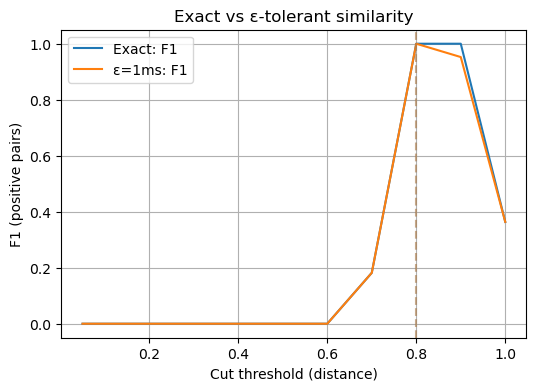

In [20]:
# Example: try ε-tolerant overlap with eps=1 ms
eps = 1
tol_sim = lambda A, B: sim_overlap_min_tolerant(A, B, eps=eps)

lab_tol = ClusteringLab(windows, y_true, sim=tol_sim)
res_tol = lab_tol.sweep_thresholds(thresholds)

print(f"[ε-tolerant, ε={eps}ms] Best:", res_tol.best)

fig, ax = plt.subplots(1,1)
ax.plot(res.thresholds, res.pair_f1, label="Exact: F1")
ax.plot(res_tol.thresholds, res_tol.pair_f1, label=f"ε={eps}ms: F1")
ax.axvline(res.best["threshold"], linestyle="--", alpha=0.4)
ax.axvline(res_tol.best["threshold"], linestyle="--", alpha=0.4, color="C1")
ax.set_xlabel("Cut threshold (distance)")
ax.set_ylabel("F1 (positive pairs)")
ax.set_title("Exact vs ε-tolerant similarity")
ax.legend()
plt.show()


Motif template:


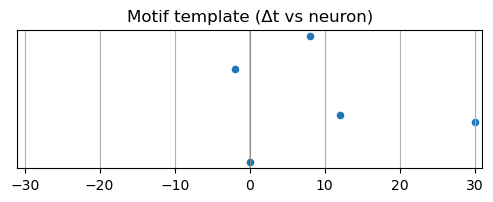

Two positive windows:


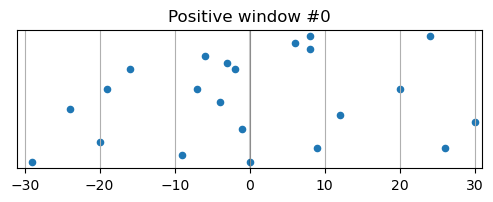

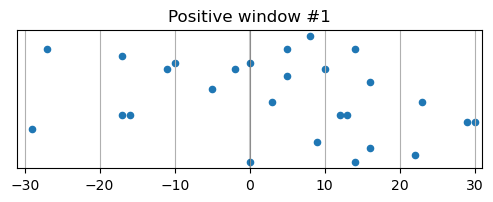

Two negative windows:


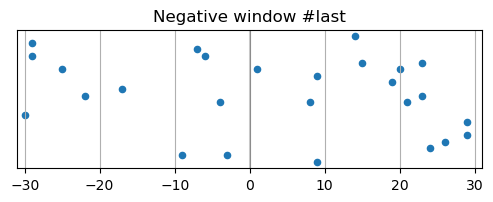

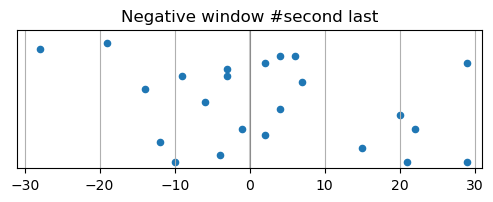

In [21]:
def plot_window(window: Window, cfg: BenchConfig, title=""):
    if len(window) == 0:
        print("(empty)")
        return
    arr = np.array(list(window))
    dt = arr[:,0]
    nn = arr[:,1]
    plt.figure(figsize=(6,1.8))
    plt.scatter(dt, nn, s=20)
    plt.axvline(0, color="k", alpha=0.2)
    plt.xlim(-cfg.D-1, cfg.D+1)
    plt.ylim(-1, cfg.N)
    plt.yticks([])
    plt.title(title)
    plt.show()

print("Motif template:")
plot_window(info["motif"], cfg, title="Motif template (Δt vs neuron)")

print("Two positive windows:")
plot_window(windows[0], cfg, title="Positive window #0")
plot_window(windows[1], cfg, title="Positive window #1")

print("Two negative windows:")
plot_window(windows[-1], cfg, title="Negative window #last")
plot_window(windows[-2], cfg, title="Negative window #second last")
